In [15]:
import torch
from models.paddedgrid_vae import VAE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(
    in_channels=11, 
    num_classes=11, 
    base_filters=64, 
    latent_dim=32,
).to(device)

checkpoint = torch.load('../../checkpoints/vae_checkpoint_epoch.pt', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [16]:
from models.paddedgrid_vae import get_training_data, GridDataset, DataLoader, custom_collate

model.eval()
z_list = []
labels_list = []

# Load the data
grids = get_training_data(filepath="../../data/training")
print(f"Loaded {len(grids)} grids")

# Create dataset and dataloader
dataset = GridDataset(grids)
batch_size = 4
loader = DataLoader(
    dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=custom_collate
)

with torch.no_grad():
    for data in loader:
        data = data.to(device)
        mu, logvar, _ = model.encode(data)  # Assuming your model has an `encode()` method
        z = mu  # Use mu for stable representation
        z_list.append(z.cpu())
        #labels_list.append(labels)  # Optional: if you have labels like grid type

z_vectors = torch.cat(z_list).numpy()

Loaded 2604 grids


/Users/alexandermirchev/Dev/thesis/arc-agi-compression-experiments/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/var/folders/x_/1hf63s3j2m7bc3xtjhjglm780000gn/T/ipykernel_59312/191827777.py:10: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(z_2d[:, 0], z_2d[:, 1], cmap='tab10')


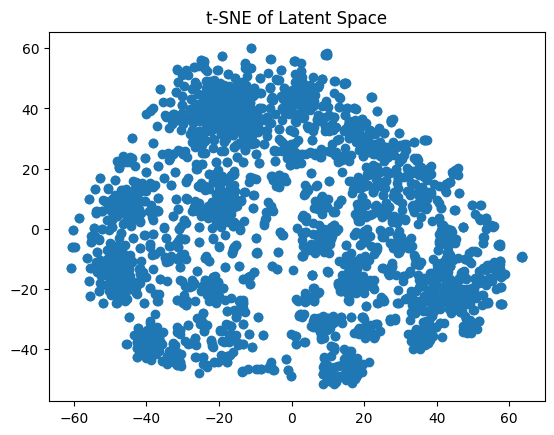

In [18]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

B = z_vectors.shape[0]
z_flat = z_vectors.reshape(B, -1)

tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
z_2d = tsne.fit_transform(z_flat)

plt.scatter(z_2d[:, 0], z_2d[:, 1], cmap='tab10')
plt.title("t-SNE of Latent Space")
plt.show()